# $k$-nearest neighbors
The $k$-nearest neighbors algorithm (KNN) is our first nonparametric algorithm. Given some testing datapoint input $x^*$, KNN finds the $k$ training datapoints nearest to $x^*$. Then, KNN infers the properties of $x^*$ based on the properties of these $k$ neighbors. The principle is that a given datapoint should have similar properties as the datapoints nearby to it. 

We have previously used single-neuron classifiers, like the Perceptron and Logistic Regression, to distinguish between Duplo- and Bionicle-theme LEGO sets. Let's see if we can use KNN to distinguish between three LEGO set themes: Duplo, Bionicle, and Education. We will again use Pieces (the number of pieces in the set) and Weight (weight of the set) to predict the theme. We will later add a third feature, representing the USD retailer-recommended price of each set.

We will normalize our data feature vectors so that all the values range from 0 to 1. We do so by dividing each feature's value by the maximum value of that feature among all sets. This is because the KNN algorithm computes the distances between datapoints, which is very sensitive to the scale of the feature values.

The below scatterplot indicates that Duplo and Bionicle sets are linearly separable. But the Education sets are very mixed and integrated into the space occupied by Duplo and Bionicle sets. It will be more challenging to separate Education sets from the other two themes.

             Theme    Pieces    Weight       RRP
Number                                          
9389-1   Education  1.000000  0.760095  0.588292
9594-1   Education  0.715784  1.000000  0.514635
45100-1  Education  0.601468  0.558195  0.341080
8759-1    Bionicle  0.448873  0.532067  0.235329
45560-1  Education  0.447299  0.546318  0.294014


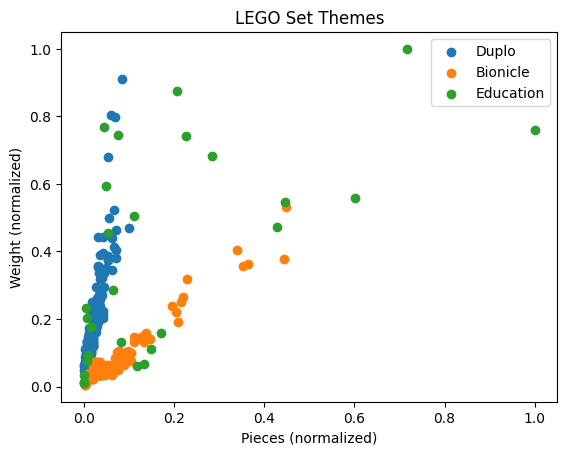

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Read in dataset and keep relevant columns/rows
df = pd.read_csv('../Data/Brickset-Most-Owned-Query-33-02042023.csv', index_col="Number")
df = df.filter(["Theme", "Pieces", "Weight", "RRP (USD)"])
df.columns = ["Theme", "Pieces", "Weight", "RRP"]
df = df[(df["Theme"] == "Duplo")
        | (df["Theme"] == "Bionicle")
        | (df["Theme"] == "Education")]
df = df.dropna()

# Normalize feature values
for feature in ["Pieces", "Weight", "RRP"]:
    df[feature] = df[feature] / df[feature].max()
print(df.head())

# Plot datapoints
themes = ["Duplo", "Bionicle", "Education"]
for theme in themes:
    bool_inds = df["Theme"] == theme
    plt.scatter(df["Pieces"][bool_inds], df["Weight"][bool_inds], label=theme)
plt.legend()
plt.title("LEGO Set Themes")
plt.xlabel("Pieces (normalized)")
plt.ylabel("Weight (normalized)")
plt.show()

Before proceeding further, let's split our data into training and testing data.

In [2]:
X_train, X_test, y_train, y_test = train_test_split(df[["Pieces", "Weight"]].to_numpy(),
                                                    df["Theme"].to_numpy(), 
                                                    test_size=0.3, 
                                                    random_state=0)

## Algorithm
The algorithm for KNN is fairly straightforward. Suppose we are given training dataset with input variables $x^i \in \mathbb{R}^m$ and response variables $y^i$ for $i \in \{1, ..., n\}$. If we want to use KNN to classify data, then $y^i$ will be from a discrete set of categorical labels. If we instead want to use KNN to perform regression, then $y^i \in \mathbb{R}$. (We will be using classification for our LEGO set theme example, but we also describe how KNN regression works just to be thorough.)

We need to first define a distance metric $d$, where $d(x_1, x_2)$ computes the distance between two input variables. Commonly, we just use Euclidean distance: $d(x_1, x_2) = ||x_1 - x_2||_2 = \sqrt{(x_1 - x_2)^2}$.

To perform KNN to perform classification/regression on some testing datapoint with input vector $x^* \in \mathbb{R}^m$, we can use the following procedure:

1. For each $i \in \{1, ..., n\}$, compute $d(x^*, x^i)$.
2. Sort all the $d(x^*, x^i)$ in ascending order.
3. Identify the $k$ smallest distances from among $d(x^*, x^i)$. Denote the indices of these $k$ nearest neighbors as $i_1, ..., i_k$. (I.e., $x^{i_1}, ..., x^{i_k}$ are the $k$ training input variables nearest to $x^*$.)
4. If classification: Return the most common label from among $y^{i_1}, ..., y^{i_k}$.
5. If regression: Return the average of the response values from among $y^{i_1}, ..., y^{i_k}$.

In [3]:
class KNearestNeighbors:
    
    k = 1           # the number of neighbors to search for in KNN algorithm
    train_X = None  # training dataset input vectors; as (n, m)-shape numpy array, where n is the data size and m is the number of features
    train_y = None  # training dataset response values; as (n,)-shape numpy array, where n is the data size
    
    def __init__(self, k, train_X, train_y):
        '''
        Initializes this KNearestNeighbors object.
        INPUT
            k, the number of neighbors to search for in KNN algorithm
            train_X; training dataset input vectors; as (n, m)-shape numpy array, where n is the data size and m is the number of features
            train_y; training dataset response values; as (n,)-shape numpy array, where n is the data size
        '''
        self.k = k
        self.train_X = train_X
        self.train_y = train_y
    
    def distance(self, x_1, x_2):
        '''
        Computes the Euclidean distance between two input vectors
        INPUT
            x_1, x_2; two numpy arrays of equal shape
        RETURNS
            Euclidean distance between x_1, x_2
        '''
        return np.sqrt(np.sum(np.square(x_1 - x_2)))
    
    def k_nearest_neighbors(self, test_x):
        '''
        Finds the k nearest neighbors to input testing datapoint.
        INPUT
            test_x; a single testing datapoint's input vector; as (n,)-shape numpy array
        RETURNS
            k-length list of the nearest neighbors to test_x. The list contains 3-tuples:
                tuple[0]: response value of the neighbor (y^i)
                tuple[1]: input vector of the neighbor (x^i)
                tuple[2]: distance from test_x to the neighbor d(x^*, x^i)
        '''
        # Compute the distance between test_x and each train_X. Also record the properties of each train_X
        neighbors = [(response_value, input_vector, self.distance(test_x, input_vector)) 
                     for input_vector, response_value in zip(self.train_X, self.train_y)]
        
        # Sort neighbors by distance
        neighbors.sort(key=lambda nbr: nbr[2])
        
        # Return properties of k nearest neighbors
        return neighbors[: self.k]
    
    def predict(self, test_x, classifier=True):
        '''
        Makes a prediction on a single testing datapoint
        If classifier, then returns the most common category label of these k neighbors
        If not classifier, then regression, so returns the average of the response value of these k neighbors
        INPUT
            test_x; a single testing datapoint's input vector; as (n,)-shape numpy array
            classifier; whether to classify or regression
        RETURNS
            if classifier, returns the most common label among k nearest neighbors
            else, returns the average of the response value of the k nearest neighbors
        '''
        # Find response values of k nearest neighbors
        neighbors = self.k_nearest_neighbors(test_x)
        response = [nbr[0] for nbr in neighbors]
        
        # If classifier, return most common label
        if classifier:
            return max(response, key=response.count)
        
        # If regression, return the average response value
        else:
            return sum(response) / self.k

## Testing
Let's test our implementation! What happens when we try to predict the LEGO set theme of the first 4 of the testing data. It's a nonparametric model, so no training is required!

In [4]:
k = 5
knn = KNearestNeighbors(k, X_train, y_train)

for ind in range(4):
    print("----- Testing datapoint #" + str(ind) + " -----")
    print("Testing datapoint input:    " + str(X_test[ind, ]))
    print("Testing datapoint label:    " + str(y_test[ind]))
    print("Predicted datapoint label:  " + str(knn.predict(X_test[ind, ], classifier=True)))
    print()
    print("Properties of k nearest neighbors")
    for nbr in knn.k_nearest_neighbors(X_test[ind, ]):
        print(nbr)
    print()

----- Testing datapoint #0 -----
Testing datapoint input:    [0.03093865 0.35629454]
Testing datapoint label:    Duplo
Predicted datapoint label:  Duplo

Properties of k nearest neighbors
('Duplo', array([0.03198741, 0.35391924]), 0.0025965263536063005)
('Duplo', array([0.03513372, 0.35446983]), 0.004574730626749381)
('Duplo', array([0.03723125, 0.33491686]), 0.022284563305356005)
('Duplo', array([0.04457263, 0.33729216]), 0.023387511187959672)
('Duplo', array([0.0550603 , 0.37529691]), 0.03070740311236762)

----- Testing datapoint #1 -----
Testing datapoint input:    [0.01573152 0.09738717]
Testing datapoint label:    Duplo
Predicted datapoint label:  Duplo

Properties of k nearest neighbors
('Duplo', array([0.01415836, 0.10019964]), 0.0032225448061172276)
('Duplo', array([0.0131096 , 0.09501188]), 0.0035378660160340215)
('Duplo', array([0.0162559 , 0.10213777]), 0.0047794476776989525)
('Duplo', array([0.01206083, 0.09373515]), 0.005177951856290487)
('Duplo', array([0.01573152, 0.1034

The predictions are decent. In many cases, the predicted LEGO theme is the same as the actual theme. In cases where the predicted theme is wrong, we see that the correct theme shows up among the test datapoint's nearest neighbors, just not as commonly as the erroneous theme. Interestingly, if we had one $k=1$ nearest neighbors, we would have gotten all four of these predictions correct. In other words, including $k=5$ neighbors meant some noise was introduced by the further neighbors.

In general, the prediction results can be quite sensitive to the selection of $k$. It's up to empirics and model specifics to decide which $k$ is optimal.

Let's see how well our model performs over the entire testing dataset. (I attempted to visualize the decision regions using `mlxtend.plotting.plot_decision_regions`, but the runtime was too long. This highlights a downside of KNN. KNN doesn't really "learn" anything that lets it run faster each prediction iteration. Furthermore, computing the Euclidean distance does not scale up easily as we try to predict several testing datapoints.)

In the confusion matrix, theme 1 is Bionicle, theme 2 is Duplo, and theme 3 is Education.

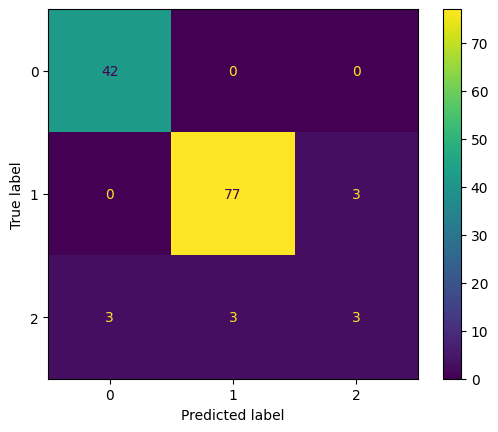

              precision    recall  f1-score   support

    Bionicle       0.93      1.00      0.97        42
       Duplo       0.96      0.96      0.96        80
   Education       0.50      0.33      0.40         9

    accuracy                           0.93       131
   macro avg       0.80      0.77      0.78       131
weighted avg       0.92      0.93      0.92       131



In [5]:
# Make predictions on testing data
prediction = [knn.predict(X_test[ind, ]) for ind in range(X_test.shape[0])]

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test.tolist(), prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test.tolist(), prediction))

The classifier performs decently. The predictions are quite accurate for Bionicle and Duplo, but the Education-theme predictions are no better than guessing randomly.

## Adding more features
KNN can operate on arbitrarily many data features, not just 2. What happens when we add "RRP" as a third data feature, which represents retail-recommended price, in dollars, for each set? Education sets become more separable with the introduction of RRP. Education sets tend to be more expensive because they contain programmable LEGO bricks for robotics projects. See the below scatterplot.

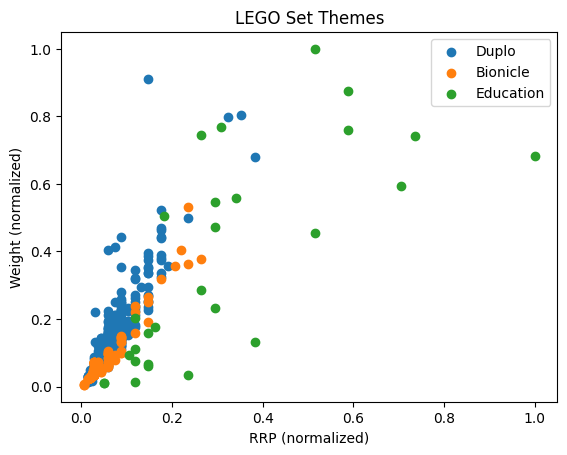

In [6]:
for theme in themes:
    bool_inds = df["Theme"] == theme
    plt.scatter(df["RRP"][bool_inds], df["Weight"][bool_inds], label=theme)
plt.legend()
plt.title("LEGO Set Themes")
plt.xlabel("RRP (normalized)")
plt.ylabel("Weight (normalized)")
plt.show()

Let's the test the new KNN model with the RRP feature.

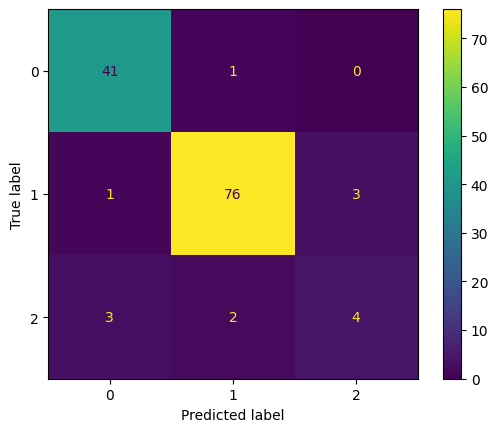

              precision    recall  f1-score   support

    Bionicle       0.91      0.98      0.94        42
       Duplo       0.96      0.95      0.96        80
   Education       0.57      0.44      0.50         9

    accuracy                           0.92       131
   macro avg       0.81      0.79      0.80       131
weighted avg       0.92      0.92      0.92       131



In [7]:
# Split train-test data
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[["Pieces", "Weight", "RRP"]].to_numpy(),
                                                    df["Theme"].to_numpy(), 
                                                    test_size=0.3, 
                                                    random_state=0)

# Make predictions
knn2 = KNearestNeighbors(k, X_train2, y_train2)
prediction = [knn2.predict(X_test2[ind, ]) for ind in range(X_test2.shape[0])]

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test2.tolist(), prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test2.tolist(), prediction))

Well, the model doesn't seem to improve much. The predictions for Bionicle and Duplo are a bit less accurate but are still highly successful from the big-picture standpoint. The predictions for Education seems to improve a little bit. This is unfortunate but not entirely unexpected, considering how closely mixed the Education sets are within the Bionicle and Duplo sets.

## Recommendations based on nearest neighbors
One cool application of KNN is that we can identify LEGO sets that are similar in weight, pieces count, and price as a given LEGO set. This is useful for marketing and recommendation systems: a customer who enjoyed the Knight's Castle 4785-1 set may be looking to purchase another LEGO set with similar complexity (based on weight and pieces count) and budget range (based on RRP).

We can make a recommendation to this customer by finding the neighbors to the Knight's Castle 4785-1 set.

In [8]:
knn_recommender = KNearestNeighbors(k=5,
                                    train_X=df.filter(["Pieces", "Weight", "RRP"]).to_numpy(),
                                    train_y=df.index)
recs = knn_recommender.k_nearest_neighbors(df.loc["4777-1", ["Pieces", "Weight", "RRP"]])

for rec in recs:
    print(rec)

('4777-1', array([0.08599895, 0.90973872, 0.14708045]), 0.0)
('9076-1', array([0.07708443, 0.74584323, 0.26474482]), 0.20195569212602008)
('10508-1', array([0.07026744, 0.79809976, 0.32354758]), 0.20940722031010303)
('9215-1', array([0.04562139, 0.7695962 , 0.30886895]), 0.21782054665001033)
('5609-1', array([0.06082853, 0.80522565, 0.35296367]), 0.2322594031685037)


The first recommendation is Knight's Castle itself, which makes sense since it has zero distance to itself, and we did not exclude Knight's Castle from the possible candidate list.

Recommendations 2-5, in order, are:
2. Tubes Experiment Set (Education)
3. Deluxe Trains Set (Duplo)
4. Dolls Family Set (Duplo)
5. Small Hub (Education)

Just from name, some of these sets don't seem to be very similar to the Knight's Castle. However, it is important to remember that these matches were based on weight, pieces count, and price.

(It may have been possible to add Theme as a fourth feature, but then we would have to derive some way to convert the categorical Theme data into something continuous that we can compute distances from. A one-hot encoding approach may have been possible but might be too complicated for this illustration.)